In [1]:
import torch
from torch import nn

# For train dataset
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
BATCH_SIZE = 128
LR = 2e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Make Train Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [4]:
latent_dim = 100
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    # Define the Generator's architecture
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 28*28),
        nn.Tanh()
    )

  def forward(self, x):
    return self.model(x)

In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(28*28, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [6]:
# Loss function
criterion = nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

# Optimizers
G_optimizer = torch.optim.Adam(generator.model.parameters(), lr=LR, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(discriminator.model.parameters(), lr=LR, betas=(0.5, 0.999))

In [7]:
EPOCH = 3

In [8]:
def train_generator(model, optim, loss_fn, images, real_labels):
    optim.zero_grad()

    # Generate fake images
    z = torch.randn(images.size(0), latent_dim).to(DEVICE)
    fake_images = model(z)

    # Compute BCELoss using fake images, with reversed labels
    outputs = discriminator(fake_images)
    G_loss = loss_fn(outputs, real_labels)

    # Optimize the Generator
    G_loss.backward()
    G_optimizer.step() 
    return G_loss

In [9]:
def train_discriminator(model, optim, loss_fn, images, real_labels, fake_labels):
    ############################
    # Train the Discriminator
    ############################
    optim.zero_grad()

    # Compute BCELoss using real images
    outputs = model(images)
    D_loss_real = loss_fn(outputs, real_labels)
    real_score = outputs

    # Generate fake images
    z = torch.randn(images.size(0), latent_dim).to(DEVICE)
    fake_images = generator(z)

    # Compute BCELoss using fake images
    outputs = model(fake_images.detach())
    D_loss_fake = loss_fn(outputs, fake_labels)
    fake_score = outputs

    # Optimize the Discriminator
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward()
    optim.step()

    return D_loss, real_score, fake_score

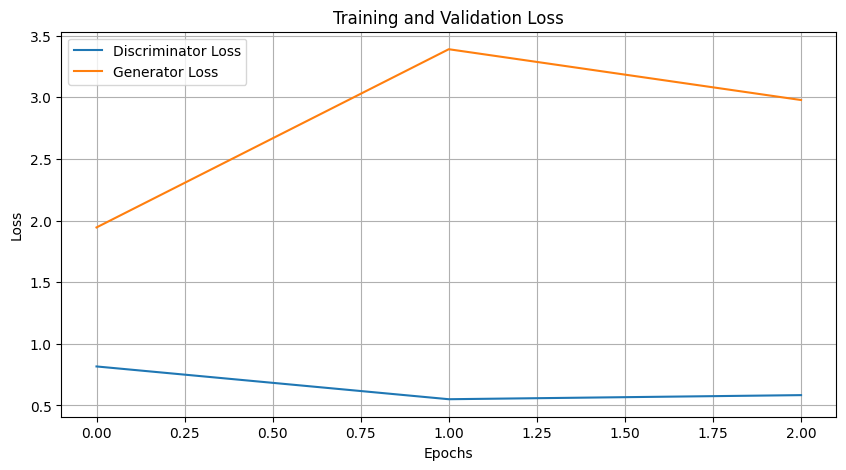

In [ ]:
generator.to(DEVICE)
discriminator.to(DEVICE)
criterion.to(DEVICE)

from IPython.display import clear_output

mean_d_losses = []
mean_g_losses = []

# Training loop
for epoch in range(EPOCH):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch [{epoch+1}/{EPOCH}]")

    d_losses = []
    g_losses = []
    for i, (images, _) in loop:
        # Flatten the images for the Discriminator
        images = images.view(images.size(0), -1).to(DEVICE)

        # Real labels are 1, fake labels are 0
        real_labels = torch.ones(images.size(0), 1).to(DEVICE)
        fake_labels = torch.zeros(images.size(0), 1).to(DEVICE)

        D_loss, real_score, fake_score = train_discriminator(discriminator, D_optimizer, criterion, images, real_labels, fake_labels)
        G_loss = train_generator(generator, G_optimizer, criterion, images, real_labels)

        d_losses.append(D_loss)
        g_losses.append(G_loss)

        # Update tqdm bar with metrics
        loop.set_postfix({
            'D_loss': f'{D_loss.item():.4f}',
            'G_loss': f'{G_loss.item():.4f}',
            'D(x)': f'{real_score.mean().item():.2f}',
            'D(G(z))': f'{fake_score.mean().item():.2f}'
        })
    mean_d_loss = sum(d_losses) / len(d_losses)
    mean_g_loss = sum(g_losses) / len(g_losses)

    mean_d_losses.append(mean_d_loss.detach().cpu().item())
    mean_g_losses.append(mean_g_loss.detach().cpu().item())

    # ✅ Live plot in Jupyter
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.pause(0.001)

torch.save(generator.state_dict(), f"generator_{BATCH_SIZE}_{LR}.pt")
torch.save(discriminator.state_dict(), f"discriminator_{BATCH_SIZE}_{LR}.pt")

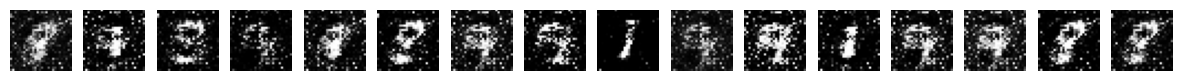

In [12]:
# Generate fake images for visualization
z = torch.randn(16, latent_dim).to(DEVICE)
fake_images = generator(z)
fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
fake_images = (fake_images + 1) / 2  # Rescale images to [0, 1]

fig, axes = plt.subplots(1, 16, figsize=(15, 15))
for ax, img in zip(axes.flatten(), fake_images):
    ax.axis('off')
    ax.set_adjustable('box')
    img = transforms.ToPILImage()(img.cpu().squeeze())
    ax.imshow(img, cmap='gray')
plt.show()